<a href="https://colab.research.google.com/github/sh20022002/small-Language-Model/blob/main/notebooks/slm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q "git+https://github.com/sh20022002/small-Language-Model.git@main"           # uses setup.py / pyproject at repo ROOT


import os, pathlib

# 1) Pick the actual clone dir you used
REPO = "/content/slm"  # change to your real clone path

# 2) Confirm the file exists (and discover the exact name/path)
!find /content -maxdepth 4 -iname "tokenizer*.pkl.gz" -print

# 3) Set the path to what you actually have (example filename below)
tok_path = f"{REPO}/src/my_slm/data/tokenizer_state.pkl.gz"


  Preparing metadata (setup.py) ... done


In [2]:
from datasets import load_dataset

from functools import partial

from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence

from my_slm.hybrid_tokeniztion import HybridTokenizer
from my_slm.transformer import Transformer
from my_slm.train import train_model
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


dataset = load_dataset("tatsu-lab/alpaca")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-a09b74b3ef9c3b(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import os, my_slm


tok_path = os.path.join(os.path.dirname(my_slm.__file__),
                        "data", "tokenizer_state.pkl.gz")
print("Loading from:", tok_path)   # sanity
tok = HybridTokenizer.load(tok_path)


Loading from: /usr/local/lib/python3.12/dist-packages/my_slm/data/tokenizer_state.pkl.gz


In [5]:
dataset = dataset['train']

In [6]:
dataset[500]

{'instruction': 'Describe the character of Romeo from Romeo and Juliet.',
 'input': '',
 'output': 'Romeo is a tragic hero with a passionate heart. He is brave and impulsive, often making decisions without fully thinking them through. He is deeply romantic and has a heartbreaking loyalty to his family and his beloved, Juliet.',
 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe the character of Romeo from Romeo and Juliet.\n\n### Response:\nRomeo is a tragic hero with a passionate heart. He is brave and impulsive, often making decisions without fully thinking them through. He is deeply romantic and has a heartbreaking loyalty to his family and his beloved, Juliet.'}

In [7]:

class QADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Prepare raw text
        prompt = f"Q: {item['instruction']}\nA:"
        target = item['output']

        # Encode input and target using your tokenizer
        input_ids = self.tokenizer.encode(prompt, mode="flat")[:self.max_length]
        label_ids = self.tokenizer.encode(target, mode="flat")[:self.max_length]

        # Convert to tensors
        input_tensor = torch.tensor(input_ids, dtype=torch.long)
        label_tensor = torch.tensor(label_ids, dtype=torch.long)

        return {
            "input_ids": input_tensor,
            "labels": label_tensor
        }



def collate_fn(batch, pad_id=0, ignore_index=-100):
    # 1) pad to [B, T]
    ids = [b["input_ids"] for b in batch]                                  # each [T]
    ids = pad_sequence(ids, batch_first=True, padding_value=pad_id)        # [B, T]

    # 2) build attention mask from padded ids
    attn = (ids != pad_id).long()                                          # [B, T]

    # 3) labels align 1:1 with ids; ignore pads for loss
    labels = ids.clone()
    labels[ids == pad_id] = ignore_index                                   # [B, T]

    return {"input_ids": ids, "attention_mask": attn, "labels": labels}




In [8]:
# Split the dataset using the datasets library's built-in method
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)

# Access the splits
train_data_list = split_dataset['train']
val_data_list = split_dataset['test'] # The split method names the validation split 'test' by default

# Create QADataset instances from the split data
train_dataset = QADataset(train_data_list, tok)
val_dataset = QADataset(val_data_list, tok)



In [9]:


model = Transformer(
    vocab_size=len(tok.token2id),
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=2048,
    window=256
)


In [10]:

pad_id = tok.token2id["<PAD>"]      # numeric id (likely 0

# after you finish adding data to tokenizer and freeze it:
vocab = tok.vocab_size

BATCH = 8


In [11]:


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH,
    shuffle=True,
    collate_fn=partial(collate_fn, pad_id=pad_id, ignore_index=pad_id),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH,
    shuffle=False,
    collate_fn=partial(collate_fn, pad_id=pad_id, ignore_index=pad_id),
)

model.resize_token_embeddings(tok.vocab_size)

assert model.token_emb.num_embeddings == vocab
assert model.to_logits.out_features   == vocab

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)


started Training...
Epoch 1/5 - Train Loss: 8.0698, Val Loss: 7.4551, Acc: 99.14%
Epoch 2/5 - Train Loss: 6.8881, Val Loss: 6.3291, Acc: 99.70%
Epoch 3/5 - Train Loss: 5.7753, Val Loss: 5.2328, Acc: 99.86%
Epoch 4/5 - Train Loss: 4.7054, Val Loss: 4.1978, Acc: 99.94%
Epoch 5/5 - Train Loss: 3.7238, Val Loss: 3.2816, Acc: 99.96%


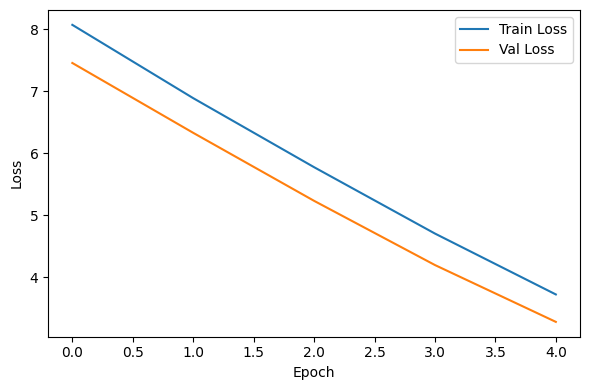

Transformer(
  (token_emb): Embedding(10678, 512)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): RMSNorm()
      (attn): MultiHeadLocalAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=False)
        (out): Linear(in_features=512, out_features=512, bias=True)
      )
      (norm2): RMSNorm()
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): SiLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
    )
  )
  (norm): RMSNorm()
  (to_logits): Linear(in_features=512, out_features=10678, bias=False)
)

In [12]:

# IMPORTANT: pass the SAME ignore_index to the trainer
train_model(model, train_loader, val_loader, optimizer, device, epochs=5, ignore_index=pad_id)


In [16]:
q = "capital of france"
e_q = tok.encode(q, mode="flat")
i_tensor = torch.tensor(e_q, dtype=torch.long)
eos_id = tok.token2id.get("<EOS>")

out = model.generate(i_tensor.unsqueeze(0).to(device), max_new_tokens=50, eos_token_id=eos_id)
print(tok.decode(out[0].tolist()))

capital of franceYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY


The `TypeError` in the `train_test_split` function arises because `sklearn`'s `train_test_split` is not designed to directly handle custom PyTorch `Dataset` objects. To resolve this, we will first split the underlying data (the list of dictionaries) into training and validation sets using `train_test_split`, and then create `QADataset` instances for each split.